# Prelim

## Single Cell Analysis Environment Setup

Follow the steps below to set up a Conda environment for single-cell analysis:

1. **Create a new conda environment named "singlecell"** with necessary packages. We use the `bioconda` and `conda-forge` channels to find packages that are not available in the default channel:

    ```bash
    conda create --name singlecell -c bioconda -c conda-forge scanpy scrublet leidenalg python-igraph jupyterlab ipykernel fa2
    ```

2. **Activate the "singlecell" environment**. You'll need to do this each time you start a new terminal session before installing new packages:

    ```bash
    conda activate singlecell
    ```

3. **Install additional Python packages** that are not available through Conda. We use `pip`, the Python package installer:

    ```bash
    pip install --upgrade scanpy 'git+https://github.com/dpeerlab/Harmony' cellxgene harmonypy pyranges palantir
    ```

4. **Register the "singlecell" environment with Jupyter**. This allows you to use the environment in Jupyter notebooks:

    ```bash
    python -m ipykernel install --user --name $CONDA_DEFAULT_ENV --display-name "$CONDA_DEFAULT_ENV"
    ```

That's all! You've now set up your single cell analysis environment. Start a Jupyter notebook server by typing `jupyter-lab` into your terminal and begin your analysis. Remember to select the kernel `singlecell` within Jupyter for your analyses.

This primer will use a dataset provided by 10X: https://support.10xgenomics.com/single-cell-gene-expression/datasets/3.0.0/pbmc_10k_protein_v3?

The raw and processed data should be downloaded to the `data/` folder.
1. [Raw data](https://fh-pi-setty-m-eco-public.s3.us-west-2.amazonaws.com/single-cell-primers/scrna/pbmc_10k_protein_v3_filtered_feature_bc_matrix.h5)
2. [Processed data](https://fh-pi-setty-m-eco-public.s3.us-west-2.amazonaws.com/single-cell-primers/scrna/pbmc_10x_rna_processed.h5ad)


# Imports

In [1]:
import os
import pandas as pd
import numpy as np

In [2]:
import scanpy as sc
import warnings

In [3]:
import palantir 
import phenograph
import harmony

findfont: Font family ['Raleway'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Lato'] not found. Falling back to DejaVu Sans.


In [4]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
# Some plotting settings we use
%matplotlib inline

sns.set_style('ticks')
matplotlib.rcParams['figure.figsize'] = [4, 4]
matplotlib.rcParams['figure.dpi'] = 100
matplotlib.rcParams['image.cmap'] = 'Spectral_r'
warnings.filterwarnings(action="ignore", module="matplotlib", message="findfont")

# Utility functions

In [6]:
def log_transform(ad, ps=0.1):
    ad.X.data = np.log2(ad.X.data + ps) - np.log2(ps)

In [7]:
from joblib import Parallel, delayed
from scipy.sparse import hstack, csr_matrix, issparse
import gc

def _dot_func(x, y):
    return x.dot(y)


def impute_data(dm_res, ad, n_steps=3):
    T_steps = dm_res['T'] ** n_steps
    T_steps = T_steps.astype(np.float32)

    # RUn in parallel
    seq = np.append(np.arange(0, ad.X.shape[1], 100), [ad.X.shape[1]])
    res = Parallel(n_jobs=-1)(delayed(_dot_func)(T_steps, ad.X[:, seq[i - 1]:seq[i]]) for i in range(1, len(seq)))
    imputed_data = hstack(res)
    imputed_data = imputed_data.todense()
    imputed_data[imputed_data < 1e-2] = 0
    gc.collect()

    return imputed_data

Cell names and genes can be seen using `ad.obs_names` and `ad.var_names` respectively

# Scanpy

[scanpy](https://scanpy.readthedocs.io/en/stable/) is the main toolkit for single-cell RNA-seq data preprocessing and analysis. [Seurat](https://satijalab.org/seurat/) is the alternative package for single-cell RNA-seq data analysis in R.

Overview of the primer: 
- We will start by understanding the `Anndata` class which is the data container of `scanpy`. 
- We will perform QC of a publicly available dataset made by available by 10X using scanpy functions. This is a single-cell RNA-seq dataset of peripheral mononuclear blood cells from a healthy donor
- We will then cluster, generating umaps and annotate cell-types in this data.

Extensive tutorials about scanpy usage are available [here](https://scanpy.readthedocs.io/en/stable/tutorials.html).

# Anndata

`AnnData` is the central data container for single-cell data. These are the main components of the an `AnnData` object.

- `.X`: Expression matrix of cells X genes (Note that in R, genes X cells representation is used). This could be raw or normalized data. 
- `.obs`: `pandas` dataframe with information about cells. Each row is a cell. The number of rows in `.obs` is same as the number of rows in `.X`. Columns contain annotations about cells. E.g., sample, cluster, cell type etc..
- `.var`: Similar to `.obs` but with information about genes.
- `.obsm`: Dictionary of matrices about cells. Each entry of `.obsm` has the same number of rows as `.X` and `.obs`. This could matrix properties such as UMAPs, PCs etc.
- `.varm`: Similar to `.obsm` for genes 
- `.uns`: Dictionary of dictionaries with unstructured information. E.g: cluster colors, cell type colors

More details on the Anndata are [here](https://anndata.readthedocs.io/en/latest/)

## Load anndata

Lets start with loading a previously computed anndata using the `scanpy.read` function. You can download the object from [here](https://fh-pi-setty-m-eco-public.s3.us-west-2.amazonaws.com/single-cell-primers/scrna/pbmc_10x_rna_processed.h5ad). Download it to the `data/` folder.

In [8]:
# Load the 10x_pbmc.h5ad object
data_dir = '../data/'
ad = sc.read(data_dir + 'pbmc_10x_rna_processed.h5ad')

In [9]:
# Print out the ad object
ad

AnnData object with n_obs × n_vars = 7462 × 11892
    obs: 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_counts', 'leiden', 'phenograph', 'doublet_score', 'predicted_doublet', 'log_n_counts', 'celltype1', 'celltype'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    obsm: 'DM_EigenVectors', 'X_FDL', 'X_pca', 'X_umap'


Download the features.tsv from [here](https://fh-pi-setty-m-eco-public.s3.us-west-2.amazonaws.com/single-cell-primers/scrna/scrna_features.tsv.gz) to `data/`. Add it to the Anndata to allow matching of gene names to ENSEMBL IDs.

In [10]:
ad.uns['features'] = pd.read_csv(data_dir + "scrna_features.tsv.gz")

## Anndata exploration

Cell names and genes can be seen using `ad.obs_names` and `ad.var_names` respectively

In [11]:
ad.obs_names

Index(['AAACCCAAGATTGTGA-1', 'AAACCCACATCGGTTA-1', 'AAACCCAGTACCGCGT-1',
       'AAACCCAGTCGTCATA-1', 'AAACCCAGTCTACACA-1', 'AAACCCAGTGCAAGAC-1',
       'AAACCCAGTGCATTTG-1', 'AAACCCATCCGATGTA-1', 'AAACCCATCTCAACGA-1',
       'AAACCCATCTCTCGAC-1',
       ...
       'TTTGTTGAGGCCACCT-1', 'TTTGTTGCACGAAAGC-1', 'TTTGTTGCAGAGGAAA-1',
       'TTTGTTGGTCTCTCAC-1', 'TTTGTTGGTGGCCACT-1', 'TTTGTTGGTTCAAGTC-1',
       'TTTGTTGGTTGCATGT-1', 'TTTGTTGGTTGCGGCT-1', 'TTTGTTGTCGAGTGAG-1',
       'TTTGTTGTCGTTCAGA-1'],
      dtype='object', length=7462)

As you can see each cell name is a nucleotide sequence indicating the cell barcode

In [12]:
ad.var_names

Index(['AL669831.5', 'LINC00115', 'FAM41C', 'NOC2L', 'KLHL17', 'HES4', 'ISG15',
       'C1orf159', 'TNFRSF18', 'TNFRSF4',
       ...
       'MT-CO3', 'MT-ND3', 'MT-ND4L', 'MT-ND4', 'MT-ND5', 'MT-ND6', 'MT-CYB',
       'AL592183.1', 'AC007325.4', 'AC004556.1'],
      dtype='object', length=11892)

Lets examine the `.obs` entry:

In [13]:
# head function lists the top n rows in the table
# Reiteration - ad.obs is just a dataframe and all pandas functions can be used.
ad.obs.head(n=10)

,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,n_counts,leiden,phenograph,doublet_score,predicted_doublet,log_n_counts,celltype1,celltype
AAACCCAAGATTGTGA-1,2194,6160.0,523.0,8.490260,6138.0,0,3,0.058450,False,3.789581,EryPre,EryPre
AAACCCACATCGGTTA-1,2093,6713.0,415.0,6.182034,6706.0,0,3,0.056487,False,3.826917,EryPre,EryPre
AAACCCAGTACCGCGT-1,1518,3637.0,287.0,7.891119,3627.0,0,2,0.069834,False,3.560743,MonoPre,MonoPre
AAACCCAGTCGTCATA-1,1240,2611.0,156.0,5.974722,2598.0,3,4,0.024521,False,3.416807,Mono2,Mono2
AAACCCAGTCTACACA-1,2022,5035.0,477.0,9.473684,5023.0,7,2,0.022418,False,3.701999,MonoPre,MonoPre
AAACCCAGTGCAAGAC-1,1753,4547.0,249.0,5.476138,4541.0,0,2,0.075285,False,3.657725,MonoPre,MonoPre
AAACCCAGTGCATTTG-1,2511,7977.0,391.0,4.901592,7958.0,7,2,0.039643,False,3.901840,MonoPre,MonoPre
AAACCCATCCGATGTA-1,962,2969.0,171.0,5.759515,2964.0,1,0,0.028454,False,3.472610,Mono,Mono
AAACCCATCTCAACGA-1,1292,3334.0,154.0,4.619076,3318.0,1,0,0.042181,False,3.522966,Mono,Mono
AAACCCATCTCTCGAC-1,1300,3852.0,163.0,4.231568,3841.0,1,0,0.064935,False,3.585686,Mono,Mono


## Subsetting anndata

Anndata objects can be subset using cell names, gene names, logical vectors for cells and genes

In [14]:
# Anndata object with cell "AAACCCAAGATTGTGA-1"
ad["AAACCCAAGATTGTGA-1", :]

View of AnnData object with n_obs × n_vars = 1 × 11892
    obs: 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_counts', 'leiden', 'phenograph', 'doublet_score', 'predicted_doublet', 'log_n_counts', 'celltype1', 'celltype'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'features'
    obsm: 'DM_EigenVectors', 'X_FDL', 'X_pca', 'X_umap'

In [15]:
# Anndata object of pDC cells
ad[ad.obs['celltype'] == 'pDC', :]

View of AnnData object with n_obs × n_vars = 0 × 11892
    obs: 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_counts', 'leiden', 'phenograph', 'doublet_score', 'predicted_doublet', 'log_n_counts', 'celltype1', 'celltype'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'features'
    obsm: 'DM_EigenVectors', 'X_FDL', 'X_pca', 'X_umap'

# Scanpy - plotting

`scanpy` contains the following broad categories of functions:

- `sc.pp`: Functions for preprocessing (Eg: PCA)
- `sc.tl`: Tool  interfaces (Eg. UMAP)
- `sc.pl`: Plotting
- `sc.external`: Interface for accessing tools developed by other labs (Eg:. `sc.external.tl.palantir`

Lets start with visualizations that we already explored using `cellxgene`

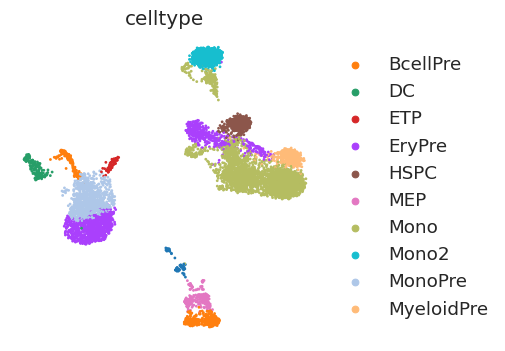

In [16]:
# Plot the umap colored by cell types
sc.pl.umap(ad, color='celltype', frameon=False)

The above function uses the `ad.obms['X_umap']` to plot the umap. If you want to use an alternative visualization, you can use the `sc.pl.scatter` function

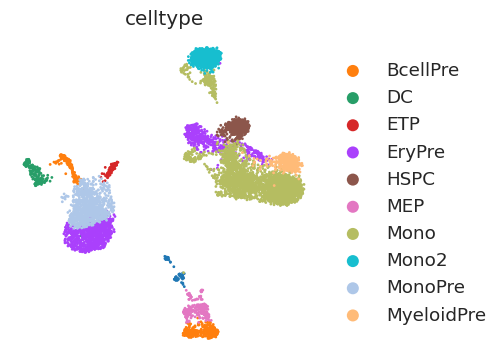

In [17]:
# Plot the umap colored by cell types
sc.pl.scatter(ad, color='celltype', basis='umap', frameon=False)

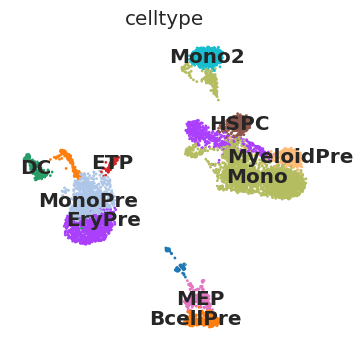

In [18]:
# We can highlight cell-types on the umap itself 
sc.pl.umap(ad, color='celltype', legend_loc='on data', frameon=False)

/home/cjordan2/.conda/envs/singlecell/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:1171: FutureWarning: Categorical.replace is deprecated and will be removed in a future version. Use Series.replace directly instead.
  values = values.replace(values.categories.difference(groups), np.nan)


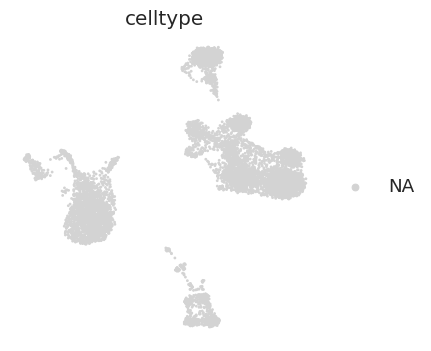

In [19]:
# Or plot specific cell types
sc.pl.umap(ad, color='celltype', groups=['pDC', 'B cell precursor'], frameon=False)

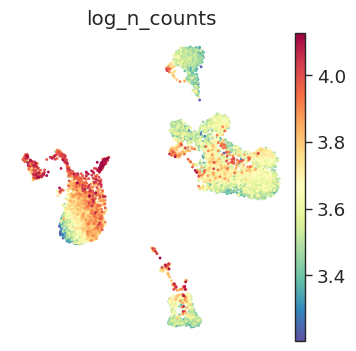

In [20]:
# UMAPs can be colored by continuous values too 
sc.pl.umap(ad, color='log_n_counts', frameon=False)

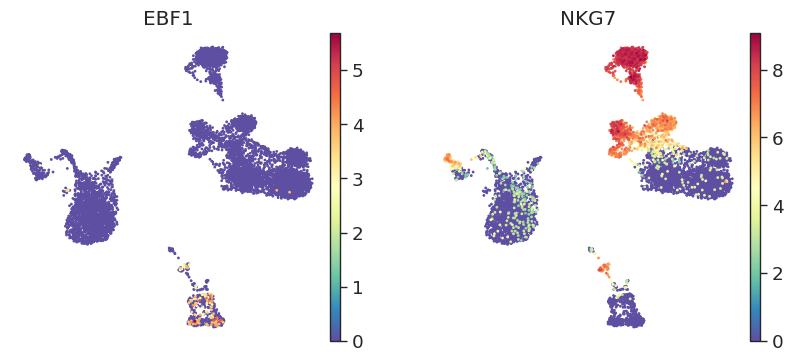

In [21]:
# Or by gene expression values 
sc.pl.umap(ad, color=['EBF1', 'NKG7'], frameon=False)

# Preprocess

This section will start with raw data and go through the preprocessing and QC

## Load data

In [22]:
ad = sc.read_10x_h5(data_dir + 'pbmc_10k_protein_v3_filtered_feature_bc_matrix.h5')
ad.var_names_make_unique()

/home/cjordan2/.conda/envs/singlecell/lib/python3.8/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [23]:
ad

AnnData object with n_obs × n_vars = 7865 × 33538
    var: 'gene_ids', 'feature_types', 'genome'

## QC

**Note:** With pandas >=1.3, `sc.pp.calculate_qc_metrics` throws a `ValueError`, should resolve in pandas >=1.4.
See [here](https://github.com/theislab/scanpy/issues/2008) for more details.

In [24]:
ad.var['mt'] = ad.var_names.str.startswith('MT-')
sc.pp.calculate_qc_metrics(ad, qc_vars=['mt'], inplace=True, percent_top=None, log1p=False, )

### Filter cell based on RNA

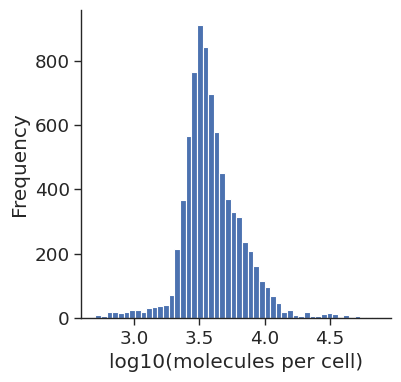

In [25]:
plt.figure()
ax = plt.gca()
ax.hist(np.log10(ad.obs['total_counts']), 50)
ax.set_xlabel('log10(molecules per cell)')
ax.set_ylabel('Frequency')
sns.despine()

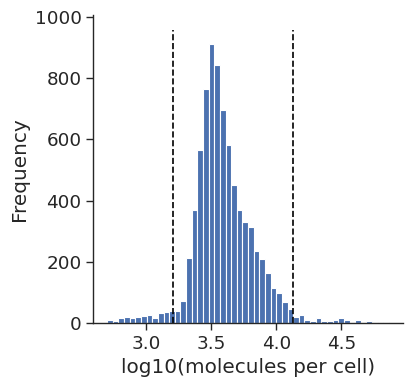

In [26]:
# Manually adjust the threshold percentage depending on the dataset
# Doublet detection (Eg: scrublet) will work better for higher molecule count cells
THRESHOLDS = np.log10(np.percentile((ad.obs['total_counts']), [3, 98]))

plt.figure()
ax = plt.gca()
ax.hist(np.log10(ad.obs['total_counts']), 50)
ax.vlines(THRESHOLDS, ax.get_ylim()[0], ax.get_ylim()[1], color='black', linestyle='--')
ax.set_xlabel('log10(molecules per cell)')
ax.set_ylabel('Frequency')
sns.despine()

In [27]:
# Filter cells 
use_cells = ad.obs_names[(np.log10(ad.obs['total_counts']) > THRESHOLDS[0]) & \
    (np.log10(ad.obs['total_counts']) < THRESHOLDS[1]) ]
ad = ad[use_cells, :]

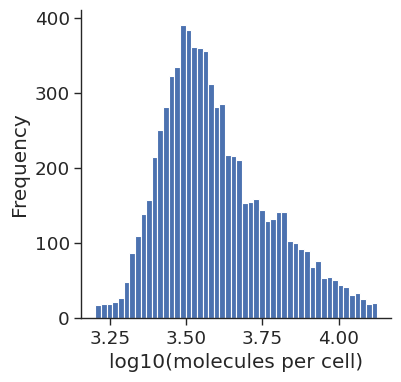

In [28]:
plt.figure()
ax = plt.gca()
ax.hist(np.log10(ad.obs['total_counts']), 50)
ax.set_xlabel('log10(molecules per cell)')
ax.set_ylabel('Frequency')
sns.despine()

### Filter based on mitochondria

In [29]:
ad.var

,gene_ids,feature_types,genome,mt,n_cells_by_counts,mean_counts,pct_dropout_by_counts,total_counts
MIR1302-2HG,ENSG00000243485,Gene Expression,GRCh38,False,0,0.000000,100.000000,0.0
FAM138A,ENSG00000237613,Gene Expression,GRCh38,False,0,0.000000,100.000000,0.0
OR4F5,ENSG00000186092,Gene Expression,GRCh38,False,0,0.000000,100.000000,0.0
AL627309.1,ENSG00000238009,Gene Expression,GRCh38,False,12,0.001526,99.847425,12.0
AL627309.3,ENSG00000239945,Gene Expression,GRCh38,False,0,0.000000,100.000000,0.0
...,...,...,...,...,...,...,...,...
AC233755.2,ENSG00000277856,Gene Expression,GRCh38,False,0,0.000000,100.000000,0.0
AC233755.1,ENSG00000275063,Gene Expression,GRCh38,False,5,0.001526,99.936427,12.0
AC240274.1,ENSG00000271254,Gene Expression,GRCh38,False,42,0.005722,99.465989,45.0
AC213203.1,ENSG00000277475,Gene Expression,GRCh38,False,0,0.000000,100.000000,0.0


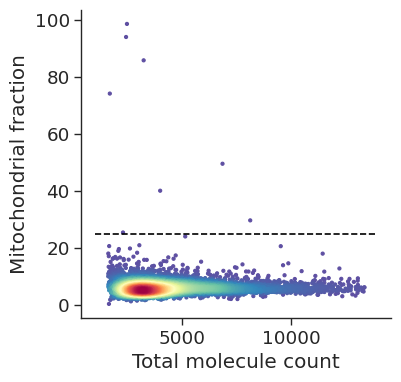

In [30]:
MITO_THRESHOLD = 25
#Mito fraction seems unusually low in this dataset
x,y,dens = palantir.plot.density_2d(ad.obs['total_counts'], 
               ad.obs['pct_counts_mt'])

plt.figure()
ax = plt.gca()
ax.scatter(x, y, c=dens, s=5)
ax.hlines(MITO_THRESHOLD, ax.get_xlim()[0], ax.get_xlim()[1], color='black', linestyle='--')

plt.xlabel('Total molecule count')
plt.ylabel('Mitochondrial fraction')
sns.despine()


In [31]:
ad = ad[ad.obs['pct_counts_mt'] < MITO_THRESHOLD, :]

In [32]:
ad

View of AnnData object with n_obs × n_vars = 7462 × 33538
    obs: 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'

## Analysis

In [33]:
# Filter genes 
sc.pp.filter_genes(ad, min_cells=50)

/home/cjordan2/.conda/envs/singlecell/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:251: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['n_cells'] = number


In [34]:
# Normalize and log transform
sc.pp.normalize_per_cell(ad)
log_transform(ad)

In [35]:
# Highly variable genes [Num. of genes is a paramter, typically 1.5-2.5k genes work well]
sc.pp.highly_variable_genes(ad, flavor='cell_ranger', n_top_genes=2500)
ad

AnnData object with n_obs × n_vars = 7462 × 11892
    obs: 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_counts'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg'

In [36]:
# PCA
sc.pp.pca(ad, use_highly_variable=True, n_comps=50)
ad
# 50 comps is an approxmiation here - choose number of components by knee point or fraction of explained variance

AnnData object with n_obs × n_vars = 7462 × 11892
    obs: 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_counts'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

In [37]:
# UMAP and Leiden - requires the computation of nearest neighbors
sc.pp.neighbors(ad, use_rep='X_pca')
sc.tl.umap(ad)
sc.tl.leiden(ad)
ad

2023-01-11 15:40:01.945671: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-11 15:40:02.088658: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-01-11 15:40:02.093576: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-01-11 15:40:02.093598: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if yo

AnnData object with n_obs × n_vars = 7462 × 11892
    obs: 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_counts', 'leiden'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'pca', 'neighbors', 'umap', 'leiden'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [38]:
# Diffusion maps 
dm_res = palantir.utils.run_diffusion_maps(pd.DataFrame(ad.obsm['X_pca'], index=ad.obs_names))
ad.obsp['DM_Kernel'] = dm_res['kernel']
ad.obsm['DM_EigenVectors'] = dm_res['EigenVectors'].values
ad.uns['DMEigenValues'] = dm_res['EigenValues'].values
ad

Determing nearest neighbor graph...


AnnData object with n_obs × n_vars = 7462 × 11892
    obs: 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_counts', 'leiden'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'pca', 'neighbors', 'umap', 'leiden', 'DMEigenValues'
    obsm: 'X_pca', 'X_umap', 'DM_EigenVectors'
    varm: 'PCs'
    obsp: 'distances', 'connectivities', 'DM_Kernel'

In [39]:
# Force directed layout
ad.obsm['X_FDL'] = harmony.plot.force_directed_layout(dm_res['kernel']).values

100%|██████████| 500/500 [00:59<00:00,  8.47it/s]

BarnesHut Approximation  took  29.14  seconds
Repulsion forces  took  26.47  seconds
Gravitational forces  took  0.17  seconds
Attraction forces  took  1.38  seconds
AdjustSpeedAndApplyForces step  took  0.85  seconds


In [40]:
# Phenograph 
ad.obs['phenograph'], _, _ = phenograph.cluster(ad.obsm['X_pca'])
ad.obs['phenograph'] = ad.obs['phenograph'].astype(str)
ad

Finding 30 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 1.3733868598937988 seconds
Jaccard graph constructed in 1.071603536605835 seconds
Wrote graph to binary file in 0.1464085578918457 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.872133
Louvain completed 21 runs in 2.8787496089935303 seconds
Sorting communities by size, please wait ...
PhenoGraph completed in 6.233964681625366 seconds


AnnData object with n_obs × n_vars = 7462 × 11892
    obs: 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_counts', 'leiden', 'phenograph'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'pca', 'neighbors', 'umap', 'leiden', 'DMEigenValues'
    obsm: 'X_pca', 'X_umap', 'DM_EigenVectors', 'X_FDL'
    varm: 'PCs'
    obsp: 'distances', 'connectivities', 'DM_Kernel'

In [41]:
# Imputation
ad.obsm['MAGIC_imputed_data'] = np.array(impute_data(dm_res, ad))

# Doublet detection

Use scrublet to detect doublets. Doublet detection should be performed per sample and prior to normalization. This command will compute the doublet scores which can be used to remove doublet clusters downstream


In [42]:
sc.external.pp.scrublet(ad)

/home/cjordan2/.conda/envs/singlecell/lib/python3.8/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


Automatically set threshold at doublet score = 0.46
Detected doublet rate = 0.1%
Estimated detectable doublet fraction = 56.3%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 0.2%


In [43]:
ad

AnnData object with n_obs × n_vars = 7462 × 11892
    obs: 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_counts', 'leiden', 'phenograph', 'doublet_score', 'predicted_doublet'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'pca', 'neighbors', 'umap', 'leiden', 'DMEigenValues', 'scrublet'
    obsm: 'X_pca', 'X_umap', 'DM_EigenVectors', 'X_FDL', 'MAGIC_imputed_data'
    varm: 'PCs'
    obsp: 'distances', 'connectivities', 'DM_Kernel'

# Visualize results

In [44]:
ad.obs['log_n_counts'] = np.log10(ad.obs['total_counts'])

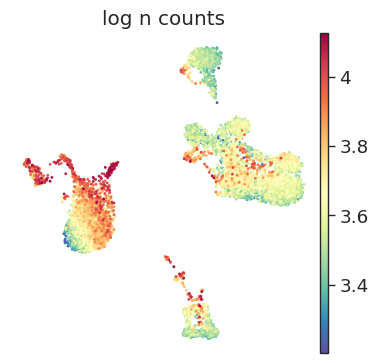

In [45]:
sc.pl.scatter(ad, basis='umap', color='log_n_counts', frameon=False)

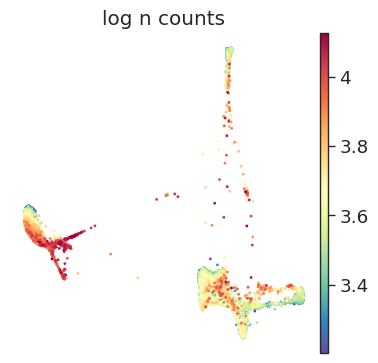

In [46]:
sc.pl.scatter(ad, basis='FDL', color='log_n_counts', frameon=False)

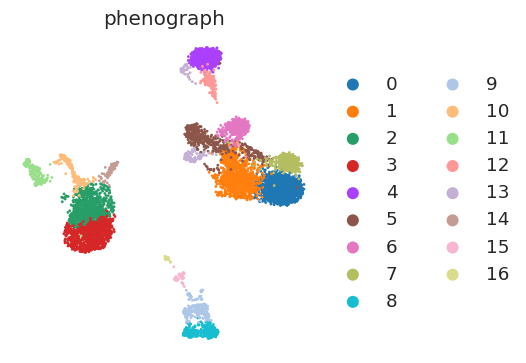

In [47]:
sc.pl.scatter(ad, basis='umap', color=['phenograph'], frameon=False)

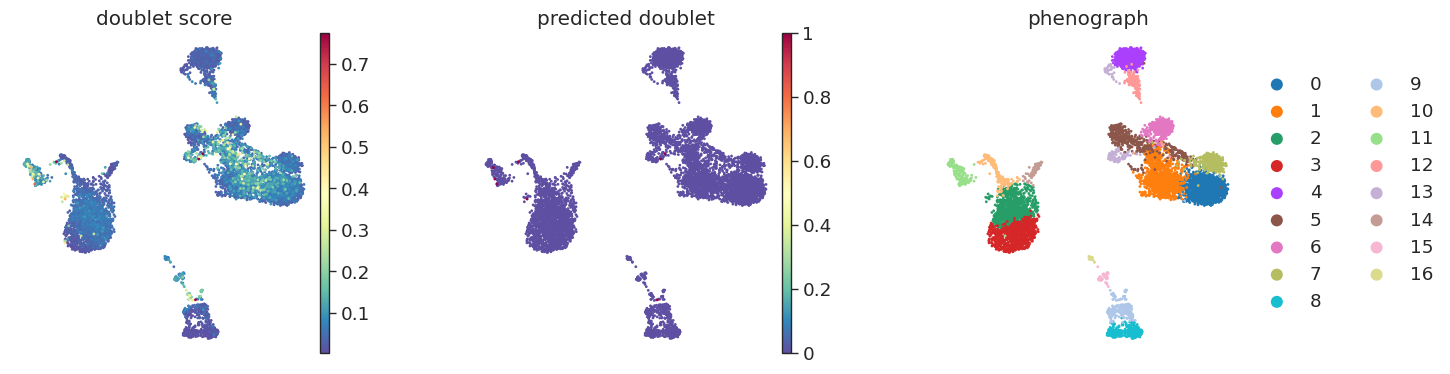

In [48]:
# Doublet scores
sc.pl.scatter(ad, basis='umap', color=['doublet_score', 'predicted_doublet', 'phenograph'], frameon=False)

# Celltype annotation

In [49]:
genes = pd.Series([
    "CD34",  #Early Progenitor
    "GATA1", #Erythroid
    "PAX5", "MS4A1", "MME", #B-Cell Trajectory
    "CD14",  #Monocytes
    "CD3D", "CD8A", 'CD4', #TCells,
    'FCGR3A', #'CD16', 
     'LEF1', 'NKG7', 'TREM1', 'LYZ', 'CD19',  'IRF8', 'IRF4',
    'ITGA2B', # CD41,
    'NCAM1', # CD56,
    'CCR7' # Memory T cell
])
genes = genes[genes.isin(ad.var_names)]

In [50]:
imp_df = pd.DataFrame(ad.obsm['MAGIC_imputed_data'], 
                                                index=ad.obs_names, columns=ad.var_names)



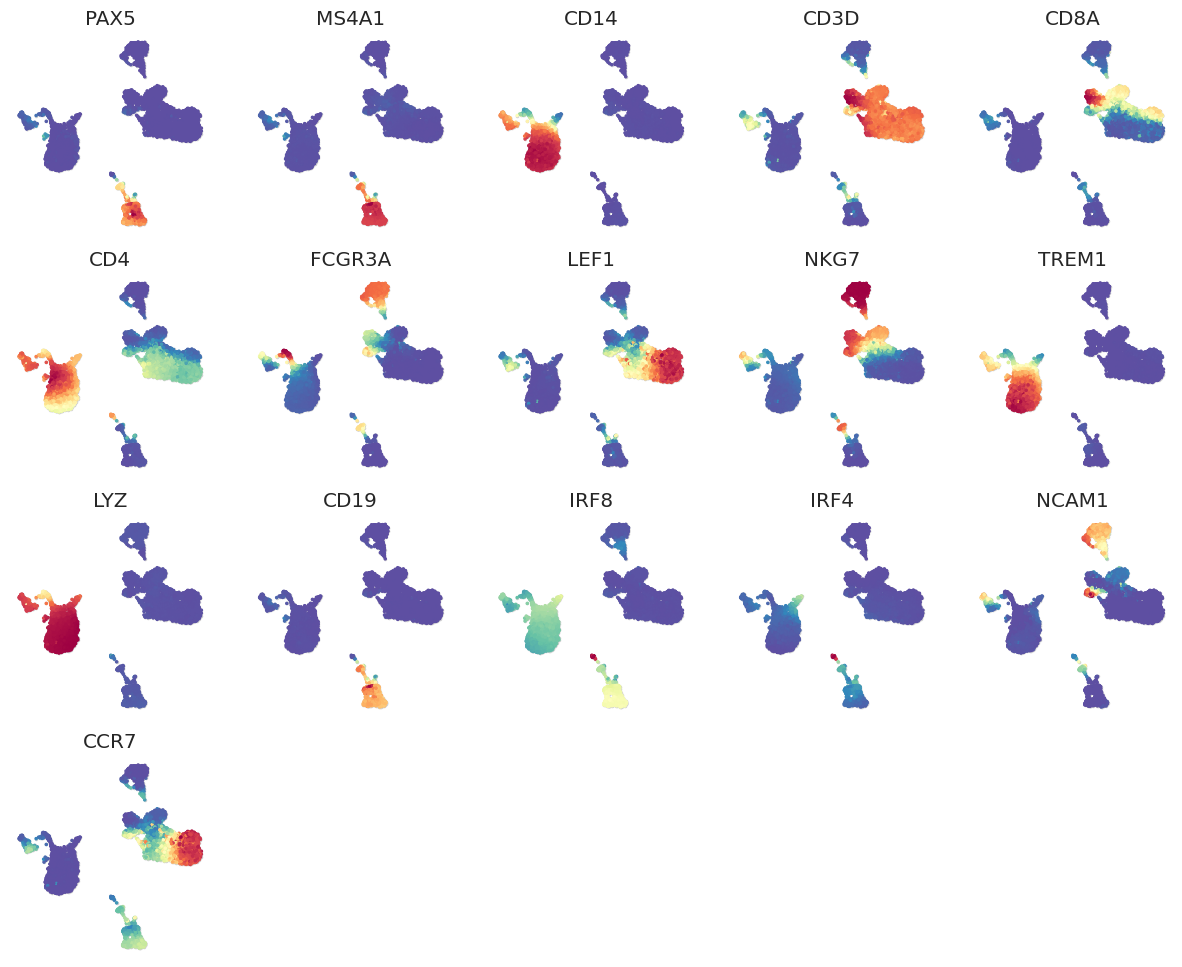

In [51]:
palantir.plot.plot_gene_expression(imp_df,
                                   pd.DataFrame(ad.obsm['X_umap'], 
                                               index=ad.obs_names, columns=['x', 'y']), 
                                   genes)

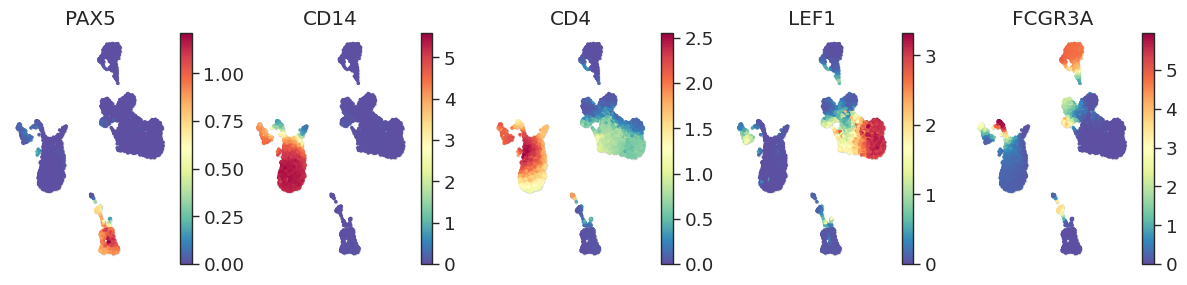

In [52]:
palantir.plot.plot_gene_expression(imp_df,
                                   pd.DataFrame(ad.obsm['X_umap'], 
                                               index=ad.obs_names, columns=['x', 'y']), 
                                   ['PAX5', 'CD14', 'CD4', 'LEF1', 'FCGR3A'], plot_scale=True)

/home/cjordan2/.conda/envs/singlecell/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:239: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/home/cjordan2/.conda/envs/singlecell/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:258: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(


Text(0.5, 1.0, 'B cell signature')

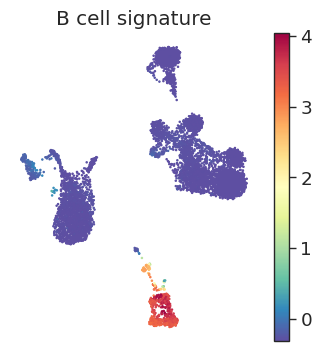

In [53]:
## Gene signatures 
bcell_signature = ["PAX5", "MS4A1"]

# Z-transform expression
from sklearn.preprocessing import scale
scaled_exprs = pd.DataFrame(scale(imp_df[bcell_signature]), index=imp_df.index, columns=bcell_signature)

# Aggregate 
vals = scaled_exprs.mean(axis=1)
plt.scatter(ad.obsm['X_umap'][:, 0], ad.obsm['X_umap'][:, 1], s=1, 
           c=vals)
plt.colorbar()
ax = plt.gca()
ax.set_axis_off()
plt.title('B cell signature')

In [54]:
ad.obs

,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,n_counts,leiden,phenograph,doublet_score,predicted_doublet,log_n_counts
AAACCCAAGATTGTGA-1,2194,6160.0,523.0,8.490260,6138.0,0,3,0.058450,False,3.789581
AAACCCACATCGGTTA-1,2093,6713.0,415.0,6.182034,6706.0,0,3,0.056487,False,3.826917
AAACCCAGTACCGCGT-1,1518,3637.0,287.0,7.891119,3627.0,0,2,0.069834,False,3.560743
AAACCCAGTCGTCATA-1,1240,2611.0,156.0,5.974722,2598.0,3,4,0.024521,False,3.416807
AAACCCAGTCTACACA-1,2022,5035.0,477.0,9.473684,5023.0,7,2,0.022418,False,3.701999
...,...,...,...,...,...,...,...,...,...,...
TTTGTTGGTTCAAGTC-1,2178,5830.0,323.0,5.540309,5812.0,12,15,0.121145,False,3.765669
TTTGTTGGTTGCATGT-1,1256,4096.0,256.0,6.250000,4086.0,5,0,0.044920,False,3.612360
TTTGTTGGTTGCGGCT-1,1907,5524.0,574.0,10.391021,5514.0,0,2,0.088260,False,3.742254
TTTGTTGTCGAGTGAG-1,1605,4039.0,271.0,6.709581,4028.0,6,6,0.039643,False,3.606274


In [55]:
cell_types = pd.Series("", index=ad.obs['phenograph'].values.categories)
cell_types['0'] = 'Mono'
cell_types['1'] = 'Mono'
cell_types['2'] = 'MonoPre'
cell_types['3'] = 'EryPre'
cell_types['4'] = 'Mono2'
cell_types['5'] = 'EryPre'
cell_types['6'] = 'HSPC'
cell_types['7'] = 'MyeloidPre'
cell_types['8'] = 'BcellPre'
cell_types['9'] = 'MEP'
cell_types['10'] = 'DC'
cell_types['11'] = 'Mono'
cell_types['12'] = 'BcellPre'
cell_types['13'] = 'Mono'
cell_types['14'] = 'ETP'




In [56]:
ad.obs['celltype'] = cell_types[ad.obs['phenograph']].values

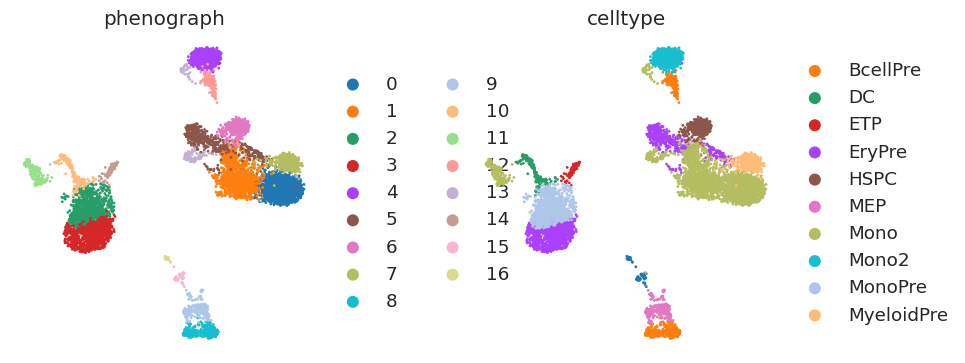

In [57]:
sc.pl.scatter(ad, basis='umap', color=['phenograph', 'celltype'], frameon=False)

# Save

In [58]:
ad.write('../data/pbmc_10x_rna_processed.h5ad')